---

## Instalação de Dependências 🔧📦

Neste passo, instalamos todas as bibliotecas necessárias para executar o notebook, incluindo ferramentas de análise de dados, visualização, aprendizado de máquina e deep learning.

---

**Resumo do passo:**

- 📦 **Bibliotecas instaladas:**  
  - `yfinance`  
  - `pandas`  
  - `numpy`  
  - `matplotlib`  
  - `scikit-learn`  
  - `tensorflow`  
- 🤖 **Objetivo:** Garantir que todas as dependências estejam disponíveis para execução do código

> 💡 *Dica: O parâmetro `-q` suprime mensagens detalhadas durante a instalação.*

---

In [22]:
!pip install yfinance pandas numpy matplotlib scikit-learn tensorflow -q 


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


---

## Importação das Bibliotecas 📚🐍

Neste passo, realizamos a importação de todas as bibliotecas e módulos necessários para manipulação de dados, construção de modelos preditivos e visualização dos resultados.

---

**Resumo do passo:**

- 📥 **Coleta de dados:** `yfinance`  
- 📊 **Manipulação e análise:** `pandas`, `numpy`  
- 📈 **Visualização:** `matplotlib.pyplot`  
- ⚙️ **Pré-processamento:** `MinMaxScaler`, `PolynomialFeatures`  
- 📐 **Modelos:** `LinearRegression`, `Ridge`, `Pipeline`  
- 🧠 **Redes neurais:** `Sequential`, `SimpleRNN`, `LSTM`, `GRU`, `Dense`  
- 🛑 **Callback:** `EarlyStopping`  
- 🧪 **Validação e métricas:** `TimeSeriesSplit`, `mean_squared_error`, `mean_absolute_error`

> 💡 *Dica: Mantenha as importações organizadas no início do notebook para melhor legibilidade e manutenção do código.*

---


In [23]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline, Pipeline

---

## Configuração dos Hiperparâmetros 🔧

Neste passo, definimos os hiperparâmetros básicos para todos os modelos utilizados na previsão das séries temporais.

---

**Resumo do passo:**

- 🔁 **Look-back:** 30  
- 📦 **Batch size:** 32  
- 🧠 **Épocas por modelo:**  
  - Ridge: 1  
  - Poly3: 1  
  - SimpleRNN: 100  
  - LSTM: 100  
  - GRU: 100  

> 💡 *Dica: Modelos lineares requerem apenas 1 época; redes neurais exigem mais iterações para convergência.*

---

In [24]:
look_back = 30
batch_size = 32
epochs_dict = {
    "Ridge": 1,     # regressão linear não precisa de muitas "épocas"
    "Poly3":  1,     # regressão linear não precisa de muitas "épocas"
    "SimpleRNN": 100,
    "LSTM": 100,
    "GRU": 100
}

---

## Download e Tratamento de Dados 📥🧹

Neste passo, realizamos o download da série temporal do Bitcoin (`BTC-USD`) a partir de 01/01/2014 e aplicamos tratamentos iniciais para garantir a frequência e integridade dos dados.

---

**Resumo do passo:**

- 🏷️ **Ticker:** BTC-USD  
- 📅 **Início:** 01/01/2014  
- 📊 **Coluna usada:** Close  
- 🕒 **Frequência forçada:** Diária (`asfreq('D')`)  
- 🔄 **Preenchimento de dados faltantes:** Forward fill (`ffill()`)

> 💡 *Dica: A limpeza garante que não haja interrupções na sequência temporal, o que é essencial para modelagem com redes neurais.*

---

In [25]:
df = yf.download('BTC-USD', start='2014-01-01')[['Close']]
df = df.asfreq('D')      # garante frequência diária
df = df.ffill()          # preenche valores faltantes

C:\Users\thmaran\AppData\Local\Temp\ipykernel_18808\2890310892.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('BTC-USD', start='2014-01-01')[['Close']]
[*********************100%***********************]  1 of 1 completed


## Normalização dos Dados 📐

Neste passo, os dados de fechamento do Bitcoin são normalizados para a faixa entre 0 e 1 utilizando o `MinMaxScaler`, tornando o treinamento mais estável e eficiente.

---

**Resumo do passo:**

- ⚙️ **Scaler:** MinMaxScaler  
- 🔢 **Intervalo transformado:** [0, 1]  
- 🎯 **Coluna mantida:** Close  
- 🔣 **Features resultantes:** 1 (`n_features = 1`)

> 💡 *Dica: A normalização ajuda os modelos de machine learning a convergirem mais rapidamente e evita distorções causadas por escalas diferentes.*

---

In [26]:
#NORMALIZAÇÃO
scaler    = MinMaxScaler()
scaled    = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled, index=df.index, columns=df.columns)

# remove todas as colunas, deixando só o fechamento:
scaled_df = scaled_df[['Close']]

# atualiza o número de features (será 1)
n_features = scaled_df.shape[1]

---

## Criação das Janelas Temporais 🪟

Neste passo, a função `create_dataset` gera os pares `(X, y)` a partir dos dados normalizados, aplicando uma janela deslizante de tamanho `look_back`.

---

**Resumo do passo:**

- 🛠️ **Função:** `create_dataset`  
- 🔁 **Look-back** 
- 🎯 **Target:** Close (`y = data[i, 0]`)  
- 📦 **Saídas:**  
  - `X`: Sequências de entrada  
  - `y`: Valor futuro de fechamento

> 💡 *Dica: Cada vetor `X` contém os últimos 30 dias, e `y` é o fechamento do dia seguinte.*


In [27]:
# CRIAÇÃO DE JANELAS (LOOK_BACK)
def create_dataset(data, look_back):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i - look_back : i, :])
        y.append(data[i, 0])  # target = 'Close'
    return np.array(X), np.array(y)

X, y = create_dataset(scaled_df.values, look_back)

---

## Validação com TimeSeriesSplit 🔄📆

Neste passo, configuramos a estratégia de validação cruzada com o `TimeSeriesSplit`, que respeita a ordem temporal dos dados utilizando janelas deslizantes (rolling windows).

---

**Resumo do passo:**

- 🔢 **Tipo de split:** TimeSeriesSplit  
- 📂 **Número de divisões:** 5 (`n_splits=5`)  
- 🕒 **Preserva temporalidade:** Sim

> 💡 *Dica: Essa abordagem é ideal para séries temporais, pois evita o vazamento de dados futuros no treinamento.*

---


In [28]:
tscv = TimeSeriesSplit(n_splits=5)

---

## Definição dos Modelos 🧠📦

Neste passo, definimos um dicionário com todos os modelos utilizados, incluindo abordagens lineares, polinomiais e redes neurais recorrentes.

---

**Resumo do passo:**

- 📚 **Modelos definidos:**  
  - Ridge  
  - Poly3 (Regressão Polinomial de grau 3 + Ridge)  
  - SimpleRNN  
  - LSTM  
  - GRU  
- 🔧 **Implementação:** Funções lambda  
- 🧱 **Camadas RNN:** 32 unidades + Dense(1)

> 💡 *Dica: A estrutura com `lambda` permite instanciar novos modelos a cada repetição da validação cruzada.*

---


In [29]:
# DEFINIÇÃO DOS MODELOS
models = {
    "Ridge":    lambda: Ridge(alpha=1.0),
    "Poly3":     lambda: make_pipeline(PolynomialFeatures(degree=3, include_bias=False), Ridge(alpha=1.0) ),
    "SimpleRNN":   lambda: Sequential([SimpleRNN(32, input_shape=(look_back, n_features)), Dense(1)]),
    "LSTM":        lambda: Sequential([LSTM(32,    input_shape=(look_back, n_features)), Dense(1)]),
    "GRU":         lambda: Sequential([GRU(32,     input_shape=(look_back, n_features)), Dense(1)]),
}

---

## Cross-Validation, Métricas e Coleta de Previsões 🔁📈

Neste passo, aplicamos validação cruzada com `TimeSeriesSplit`, treinamos os modelos, comparamos os resultados e armazenamos as previsões e métricas de desempenho.

---

**Resumo do passo:**

- 🔄 **Validação:** TimeSeriesSplit (5 splits)  
- 🧠 **Treinamento:**  
  - Modelos lineares: `fit()` com reshape  
  - RNNs: `fit()` com `EarlyStopping`  
- 📏 **Métricas calculadas:**  
  - MAE (Erro Absoluto Médio)  
  - MSE (Erro Quadrático Médio)  
  - RMSE (Raiz do Erro Quadrático Médio)  
  - MAPE (Erro Percentual Absoluto Médio)  
- 📦 **Saídas armazenadas:** Previsões e valores reais invertidos da escala

> 💡 *Dica: Salvar as previsões permite gerar gráficos comparativos entre os modelos.*

---


In [30]:
# CROSS-VALIDATION, MÉTRICAS E COLETA DE PREDIÇÕES
metrics = {}
for name, build_fn in models.items():
    metrics[name] = {"mae": [], "mse": [], "rmse": [], "mape": [], "reals": [], "preds": []}
    for train_idx, test_idx in tscv.split(X):
        X_tr, X_te = X[train_idx], X[test_idx]
        y_tr, y_te = y[train_idx], y[test_idx]

        # Ajuste e predição
        if name in ("Ridge", "Poly3"):
            # Para regressão linear, achata as features
            X_tr_lr = X_tr.reshape(len(X_tr), -1)
            X_te_lr = X_te.reshape(len(X_te), -1)
            mdl = build_fn()
            mdl.fit(X_tr_lr, y_tr)
            pred = mdl.predict(X_te_lr)
        else:
            # Para RNNs, treina com EarlyStopping
            mdl = build_fn()
            mdl.compile(optimizer='adam', loss='mse')
            es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
            mdl.fit(X_tr, y_tr,
                    epochs=epochs_dict[name], batch_size=batch_size,
                    validation_split=0.1,
                    callbacks=[es],
                    verbose=0)
            pred = mdl.predict(X_te).flatten()

        # Inverter escala para métricas reais
        zeros_te  = np.zeros((len(y_te), n_features - 1))
        zeros_pr  = np.zeros((len(pred), n_features - 1))
        y_te_real = scaler.inverse_transform(np.hstack([y_te.reshape(-1,1), zeros_te]))[:,0]
        pr_real   = scaler.inverse_transform(np.hstack([pred.reshape(-1,1), zeros_pr]))[:,0]

        # Cálculo de métricas
        mse_val = mean_squared_error(y_te_real, pr_real)
        metrics[name]["mae"].append(mean_absolute_error(y_te_real, pr_real))
        metrics[name]["mse"].append(mse_val)
        metrics[name]["rmse"].append(np.sqrt(mse_val))  # sqrt(MSE)
        metrics[name]["mape"].append(np.mean(np.abs((y_te_real - pr_real) / y_te_real)) * 100)

        # Guarda séries reais e previstas para plot
        metrics[name]["reals"].extend(y_te_real.tolist())
        metrics[name]["preds"].extend(pr_real.tolist())

c:\Users\thmaran\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


c:\Users\thmaran\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


c:\Users\thmaran\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


c:\Users\thmaran\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


c:\Users\thmaran\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


c:\Users\thmaran\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


c:\Users\thmaran\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


c:\Users\thmaran\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


c:\Users\thmaran\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


c:\Users\thmaran\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


c:\Users\thmaran\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


c:\Users\thmaran\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


c:\Users\thmaran\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


c:\Users\thmaran\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


c:\Users\thmaran\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


---

## Cálculo das Médias das Métricas 📊➗

Neste passo, calculamos a média das métricas obtidas durante a validação cruzada para cada modelo, consolidando os resultados de desempenho.

---

**Resumo do passo:**

- 🧮 **Métricas médias por modelo:**  
  - `mae_avg`  
  - `mse_avg`  
  - `rmse_avg`  
  - `mape_avg`  
- 🔁 **Base de cálculo:** Resultados dos 5 splits de validação cruzada

> 💡 *Dica: As médias facilitam a comparação final entre os modelos de forma objetiva.*

---


In [31]:
# MÉDIA DAS MÉTRICAS CV
for name in models:
    for m in ("mae","mse","rmse","mape"):
        metrics[name][m + "_avg"] = np.mean(metrics[name][m])

---

## Previsão Futura (14 Dias) 📅🔮

Neste passo, cada modelo é treinado com o conjunto completo e realiza previsões iterativas para os próximos **14 dias**, com base na última janela conhecida.

---

**Resumo do passo:**

- 🧠 **Treinamento final:** Usando todo o conjunto `X`, `y`  
- 🔁 **Modelos:** Ridge, Poly3, SimpleRNN, LSTM, GRU  
- 📆 **Horizonte da previsão:** 14 dias  
- 🔂 **Modo de predição:** Iterativo, um dia por vez  
- 🔄 **Atualização da janela:** A cada predição, novo valor é inserido na sequência  
- 📊 **Resultado final:** Valores reais (invertidos do scaler)

> 💡 *Dica: Esse tipo de previsão iterativa simula um cenário real de forecast diário, onde cada valor previsto é usado como base para o próximo.*

---


In [32]:
# Previsão futura (14 dias)
future_preds = {}
last_window  = scaled_df.values[-look_back:]

for name, build_fn in models.items():
    mdl = build_fn()
    # treina no dataset completo
    if isinstance(mdl, (Pipeline, Ridge)):
        flat = X.reshape(len(X), -1)
        mdl.fit(flat, y)
    else:
        mdl.compile(optimizer='adam', loss='mse')
        es = EarlyStopping(monitor='val_loss', patience=5,
                           restore_best_weights=True)
        mdl.fit(X, y,
                epochs=epochs_dict[name],
                batch_size=batch_size,
                validation_split=0.1,
                shuffle=False,
                callbacks=[es],
                verbose=0)

    # Gera 14 dias iterativos
    seq = last_window.copy()
    preds = []
    for _ in range(14):
        if isinstance(mdl, (Pipeline, Ridge)):
            inp = seq.reshape(1, -1)
            p   = mdl.predict(inp)[0]
        else:
            inp = seq.reshape(1, look_back, n_features)
            p   = mdl.predict(inp)[0,0]
        preds.append(p)
        seq = np.vstack([seq[1:], [[p]]])

    future_preds[name] = scaler.inverse_transform(np.array(preds).reshape(-1,1))[:,0]

c:\Users\thmaran\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


c:\Users\thmaran\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


c:\Users\thmaran\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


---

## Cálculo e Visualização do Sharpe Ratio 📈📊

Neste passo, calculamos o **Sharpe Ratio** para cada modelo com base nas previsões futuras de 14 dias, considerando os horizontes diário, mensal e anual. Em seguida, os resultados são visualizados em um gráfico de barras agrupadas.

---

**Resumo do passo:**

- 💰 **Cálculo dos retornos:** `returns = prices[1:] / prices[:-1] - 1`  
- 🧮 **Sharpe Ratio por modelo:**  
  - Diário: média / desvio padrão  
  - Mensal: diário × √21  
  - Anual: diário × √252  
- 📦 **Dados armazenados:** `sharpe_stats`  
- 📊 **Gráfico gerado:** Barras comparativas (diário, mensal, anual)  
- 🎯 **Objetivo:** Avaliar risco-retorno de cada abordagem preditiva

> 💡 *Dica: O Sharpe Ratio permite comparar modelos considerando tanto o retorno quanto a volatilidade das previsões.*

---


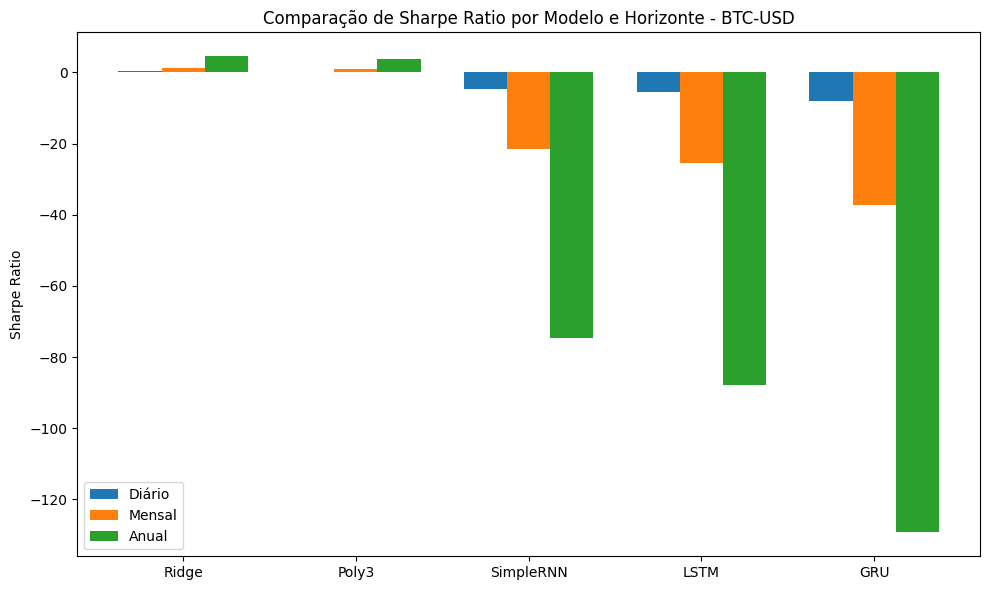

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# dicionário existente de sharpe_stats
sharpe_stats = {}
model_names  = []
sh_dailies   = []
sh_monthlies = []
sh_annuals   = []

# Calcula e imprime dentro do for, e também acumula ===
for name, prices in future_preds.items():
    returns = prices[1:] / prices[:-1] - 1
    mu    = returns.mean()
    sigma = returns.std(ddof=1)
    sh_daily   = mu / sigma
    sh_monthly = sh_daily * np.sqrt(21)
    sh_annual  = sh_daily * np.sqrt(252)

    # salva no dicionário (opcional)
    sharpe_stats[name] = {
        "daily":   sh_daily,
        "monthly": sh_monthly,
        "annual":  sh_annual
    }

    # imprime
    #print(f"{name} Sharpe Ratio:")
    #print(f"  Diário : {sh_daily:.4f}")
    #print(f"  Mensal : {sh_monthly:.4f}")
    #print(f"  Anual  : {sh_annual:.4f}\n")

    # acumula para o gráfico
    model_names.append(name)
    sh_dailies.append(sh_daily)
    sh_monthlies.append(sh_monthly)
    sh_annuals.append(sh_annual)

x     = np.arange(len(model_names))
width = 0.25

plt.figure(figsize=(10,6))
plt.bar(x - width, sh_dailies,   width, label='Diário')
plt.bar(x,         sh_monthlies, width, label='Mensal')
plt.bar(x + width, sh_annuals,   width, label='Anual')

plt.xticks(x, model_names)
plt.ylabel('Sharpe Ratio')
plt.title('Comparação de Sharpe Ratio por Modelo e Horizonte - BTC-USD')
plt.legend()
plt.tight_layout()
plt.show()


---

## Plot Comparativo de Métricas 📊⚖️

Neste passo, geramos gráficos de barras para comparar o desempenho médio dos modelos com base nas métricas **MSE**, **RMSE** e **MAPE**.

---

**Resumo do passo:**

- 📏 **Métricas comparadas:**  
  - MSE (Erro Quadrático Médio)  
  - RMSE (Raiz do Erro Quadrático Médio)  
  - MAPE (%) (Erro Percentual Absoluto Médio)  
- 🧮 **Valores usados:** Médias dos 5 folds da cross-validation  
- 📊 **Visualização:** Gráficos de barras individuais para cada métrica

> 💡 *Dica: Comparar diferentes métricas ajuda a entender tanto a precisão absoluta quanto a proporcional das previsões.*

---


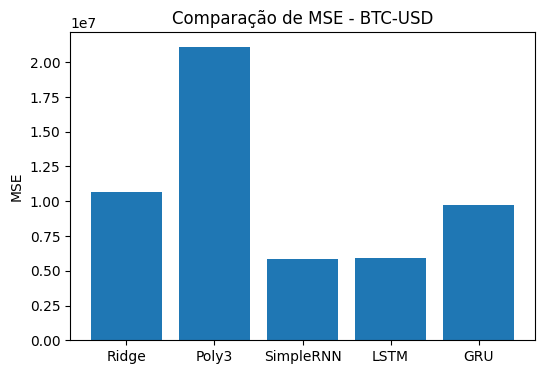

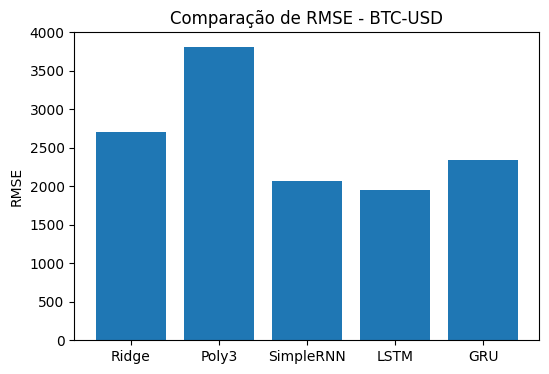

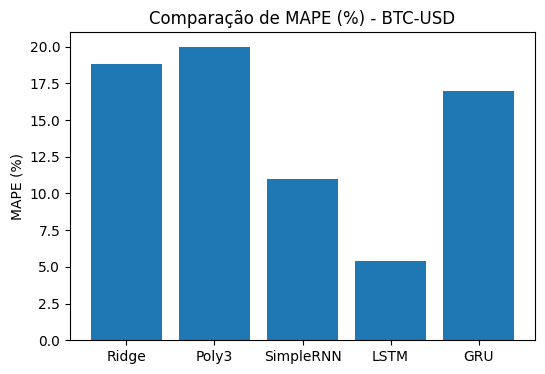

In [34]:
for m, label in [("mse_avg","MSE"), ("rmse_avg","RMSE"), ("mape_avg","MAPE (%)")]:
    plt.figure(figsize=(6,4))
    names = list(models.keys())
    vals  = [metrics[n][m] for n in names]
    plt.bar(names, vals)
    plt.title(f"Comparação de {label} - BTC-USD")
    plt.ylabel(label)
    plt.show()

---

## Plot Real x Previsto x Futuro (14 Dias) 📈🔮

Neste passo, para cada modelo, é gerado um gráfico comparando os valores reais observados, as previsões feitas durante a validação e as projeções futuras de 14 dias.

---

**Resumo do passo:**

- 📉 **Linha 1:** Série real (`Real`)  
- 📊 **Linha 2:** Previsões obtidas via cross-validation (`Previsto`)  
- 🔮 **Linha 3:** Projeção iterativa de 14 dias à frente (`Futuro`)  
- 🎯 **Objetivo:** Visualizar o desempenho preditivo e a tendência projetada

> 💡 *Dica: Essa visualização permite avaliar a aderência do modelo aos dados históricos e a consistência de sua projeção futura.*

---


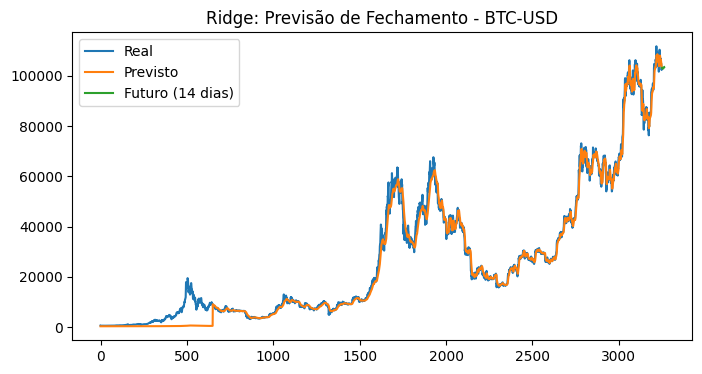

[103065.46337898 102930.84068736 102824.32995736 102809.90928292
 102824.73029799 102842.01790224 102826.46017837 102804.06478116
 102838.47592597 102933.05639039 103105.18370192 103256.46128891
 103384.43282301 103409.96837359]


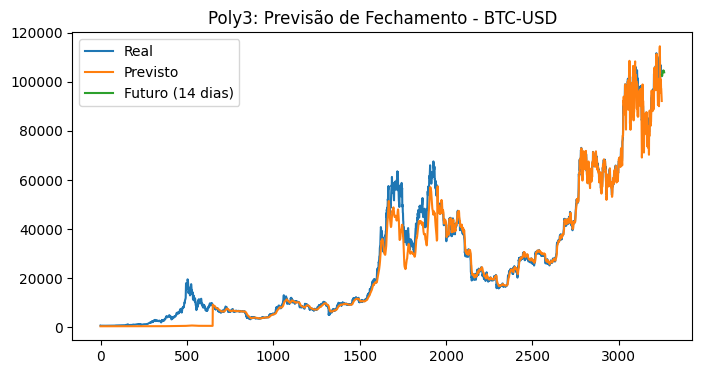

[102744.9725227  102395.80147338 102644.89951711 103583.00732117
 104124.54979158 104514.90152422 104467.04619681 104404.37001355
 104507.84986265 104387.66406895 104598.48131526 104252.14805357
 104214.93128478 103879.74015368]


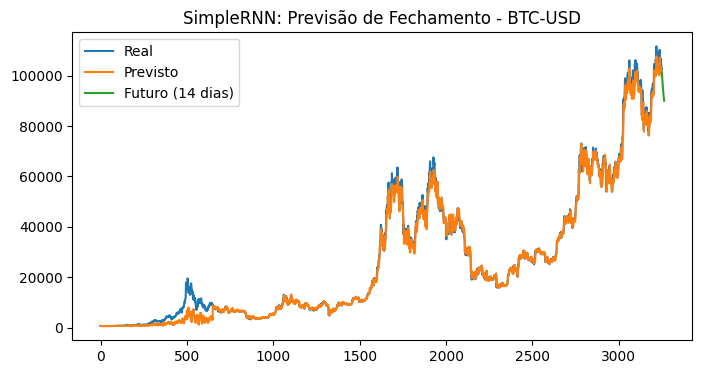

[101354.65  100079.88   99094.77   97994.79   96980.336  96077.78
  95111.45   94067.45   93322.31   92626.25   91895.23   91228.13
  90630.02   90036.09 ]


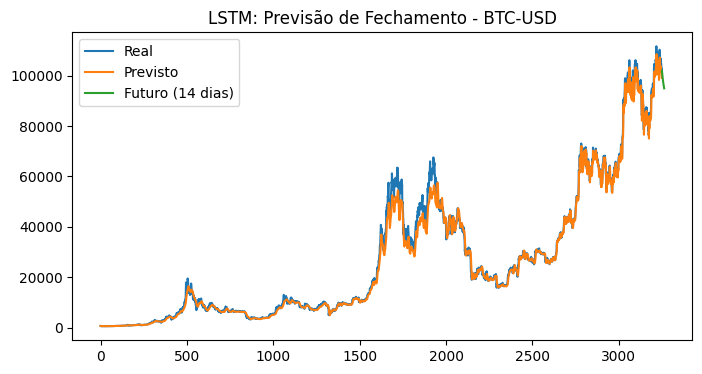

[101995.27  101328.48  100633.875  99962.81   99324.63   98721.45
  98152.445  97615.79   97109.35   96631.305  96179.97   95753.85
  95351.61   94971.945]


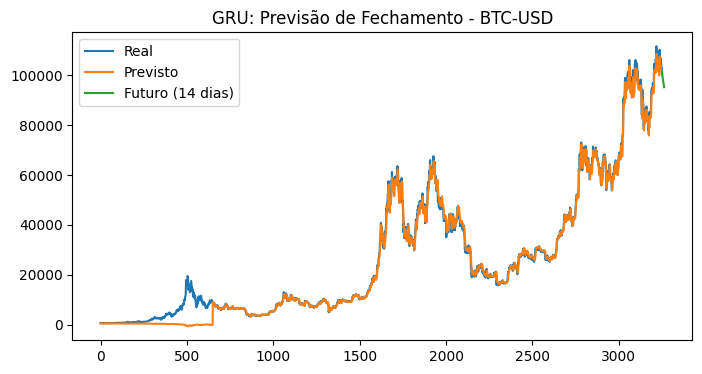

[101554.32  101017.06  100423.06   99853.72   99307.2    98783.055
  98280.2    97797.49   97333.8    96888.07   96459.38   96046.85
  95649.64   95267.016]


In [35]:
for name in models:
    real   = np.array(metrics[name]["reals"])
    pred   = np.array(metrics[name]["preds"])
    future = future_preds[name]
    plt.figure(figsize=(8,4))
    plt.plot(real, label='Real')
    plt.plot(pred, label='Previsto')
    plt.plot(np.arange(len(real), len(real)+14), future, label='Futuro (14 dias)')
    plt.title(f"{name}: Previsão de Fechamento - BTC-USD")
    plt.legend()
    plt.show()
    print(future)